# BASIC NETWORK ANALYSIS 

## Heatmap 

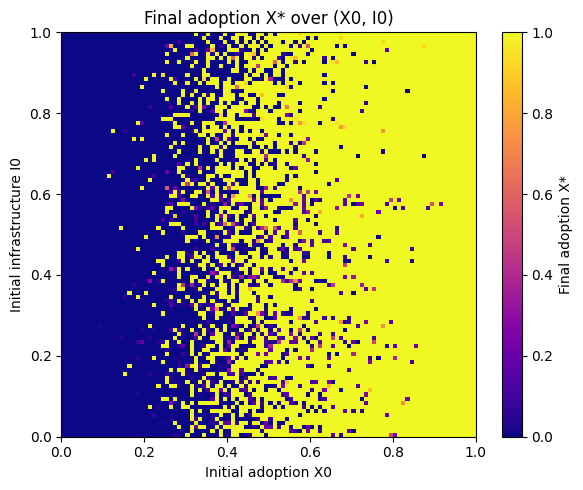

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ev_core import run_network_trial

X0_vals = np.linspace(0.0, 1.0, 100)  
I0_vals = np.linspace(0.0, 1.0, 100)    
N_SEEDS = 1
T = 250

BASE = dict(
    a0=2.3,
    beta_I=2.0,
    b=1.0,
    g_I=0.005,
    network_type="BA",
    n_nodes=200,
    m=2,
)

X_final = np.zeros((len(I0_vals), len(X0_vals)))

for i, I0 in enumerate(I0_vals):
    for j, X0 in enumerate(X0_vals):
        finals = []
        for r in range(N_SEEDS):
            seed = 1000 + 100*i + 10*j + r
            x_star = run_network_trial(
                X0_frac=X0,
                ratio=BASE["ratio"],
                I0=I0,
                beta_I=BASE["beta_I"],
                b=BASE["b"],
                g_I=BASE["g_I"],
                T=T,
                network_type=BASE["network_type"],
                n_nodes=BASE["n_nodes"],
                m=BASE["m"],
                seed=seed,
                collect=False,
                strategy_choice_func="logit", 
                tau=3.0,
            )
            finals.append(x_star)
        X_final[i, j] = np.mean(finals)

fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(
    X_final,
    origin="lower",
    extent=[X0_vals[0], X0_vals[-1], I0_vals[0], I0_vals[-1]],
    aspect="auto",
    vmin=0.0, vmax=1.0,
    cmap="plasma",
)
cbar = fig.colorbar(im, ax=ax)
cbar.set_label("Final adoption X*")
ax.set_xlabel("Initial adoption X0")
ax.set_ylabel("Initial infrastructure I0")
ax.set_title("Final adoption X* over (X0, I0)")
plt.tight_layout()
plt.savefig("heatmap_X0_I0.png", dpi=150)
plt.show()


## Heatmap with separatrix

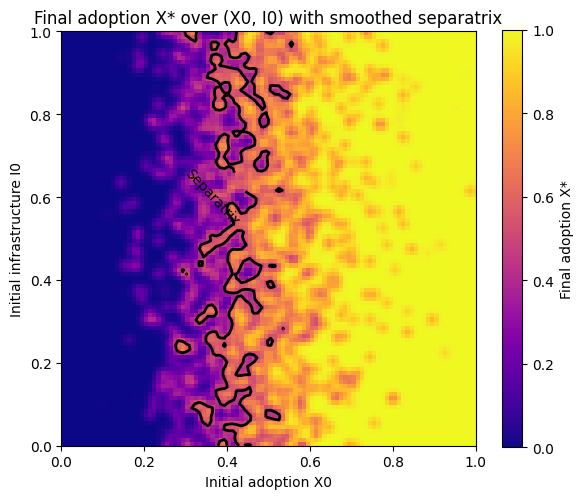

In [5]:
T = 250
N_SEEDS = 1

xg = np.linspace(0, 1, 100)
ig = np.linspace(0, 1, 100)
X0s, I0s = np.meshgrid(xg, ig)

X0_flat = X0s.flatten()
I0_flat = I0s.flatten()
N_SAMPLES = len(X0_flat)

#parametrs
BASE = dict(
    ratio=2.3,
    beta_I=2.0,
    b=1.0,
    g_I=0.005,
    network_type="BA",
    n_nodes=250,
    m=2,
)

finals = np.zeros(N_SAMPLES)

for idx in range(N_SAMPLES):
    X0 = X0_flat[idx]
    I0 = I0_flat[idx]

    f_vals = []
    for r in range(N_SEEDS):
        seed = 22*idx
        x_star = run_network_trial(
            X0_frac=X0,
            I0=I0,
            ratio=BASE["ratio"],
            beta_I=BASE["beta_I"],
            b=BASE["b"],
            g_I=BASE["g_I"],
            T=T,
            network_type=BASE["network_type"],
            n_nodes=BASE["n_nodes"],
            m=BASE["m"],
            seed=seed,
            collect=False,
            strategy_choice_func="logit",
            tau=3.0,
        )
        f_vals.append(x_star)

    finals[idx] = np.mean(f_vals)

# reshape to shape of (ig, xg)
final_grid = finals.reshape(100, 100)

from scipy.ndimage import gaussian_filter

# smooth the grid to remove stochastic discontinuities
final_smooth = gaussian_filter(final_grid, sigma=1.0)

fig, ax = plt.subplots(figsize=(6,5))

# continuous heatmap
im = ax.imshow(
    final_smooth,
    origin='lower',
    extent=[0,1,0,1],
    cmap='plasma',
    vmin=0,
    vmax=1
)

# separatrix
CS = ax.contour(
    X0s, I0s, final_smooth,
    levels=[0.5],
    colors='black',
    linewidths=2
)
ax.clabel(CS, fmt={0.5: 'Separatrix'})

ax.set_xlabel("Initial adoption X0")
ax.set_ylabel("Initial infrastructure I0")
ax.set_title("Final adoption X* over (X0, I0) with smoothed separatrix")
plt.colorbar(im, ax=ax, label="Final adoption X*")
plt.tight_layout()
plt.show()

## Sensitivity of system to $\beta_i$

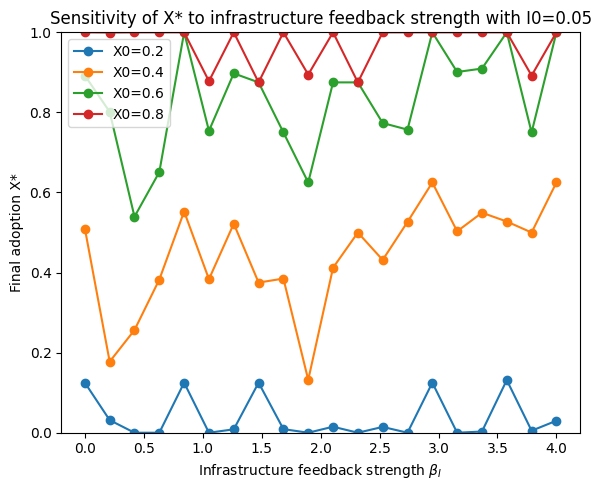

In [10]:
beta_vals = np.linspace(0.0, 4.0, 20) 
X0_list = [0.2, 0.4, 0.6, 0.8]
N_SEEDS = 8
T = 250

BASE = dict(
    ratio=2.3,
    b=1.0,
    g_I=0.005,
    I0=0.05,
    network_type="BA",
    n_nodes=250,
    m=2,
)

sens = {X0: [] for X0 in X0_list}

for beta in beta_vals:
    for X0 in X0_list:
        finals = []
        for r in range(N_SEEDS):
            seed = int(1e6 * (beta + r))
            x_star = run_network_trial(
                X0_frac=X0,
                ratio=BASE["ratio"],
                I0=BASE["I0"],
                beta_I=beta,
                b=BASE["b"],
                g_I=BASE["g_I"],
                T=T,
                network_type=BASE["network_type"],
                n_nodes=BASE["n_nodes"],
                m=BASE["m"],
                seed=seed,
                collect=False,
                strategy_choice_func="logit",
                tau=3.0,
            )
            finals.append(x_star)
        sens[X0].append(np.mean(finals))

fig, ax = plt.subplots(figsize=(6, 5))
for X0 in X0_list:
    ax.plot(beta_vals, sens[X0], marker="o", label=f"X0={X0:.1f}")
ax.set_xlabel(r"Infrastructure feedback strength $\beta_I$")
ax.set_ylabel("Final adoption X*")
ax.set_ylim(0, 1)
ax.set_title("Sensitivity of X* to infrastructure feedback strength with I0=0.05")
ax.legend()
plt.tight_layout()
plt.savefig("sensitivity_betaI.png", dpi=150)
plt.show()


# Model Networks

In [11]:
import pandas as pd
import networkx as nx
from ev_core import EVStagHuntModel, set_initial_adopters

def simulate_one_run_with_metrics(
    X0_frac,
    ratio=2.3,
    beta_I=2.0,
    b=1.0,
    g_I=0.005,
    I0=0.05,
    seed=None,
    network_type="random",
    n_nodes=250,
    p=0.05,
    m=2,
    strategy_choice_func="logit",
    tau=3.0,
) -> dict:
    a0 = ratio * b - beta_I * I0
    model = EVStagHuntModel(
        a0=a0,
        beta_I=beta_I,
        b=b,
        g_I=g_I,
        I0=I0,
        seed=seed,
        network_type=network_type,
        n_nodes=n_nodes,
        p=p,
        m=m,
        collect=False, 
        strategy_choice_func=strategy_choice_func,
        tau=tau,
    )

    # set initial adopters using your helper
    if X0_frac > 0.0:
        set_initial_adopters(
            model,
            X0_frac,
            method="random",  # or "degree" if you want targeted seeding
            seed=seed,
        )

    time_to_80 = None
    X_series = []

    for t in range(T):
        model.step()
        X = model.get_adoption_fraction()
        X_series.append(X)
        if time_to_80 is None and X >= 0.8:
            time_to_80 = t

    final_X = X_series[-1]

    # ---- cluster formation at final time ----
    G = model.G
    ev_nodes = [agent.pos for agent in model.schedule.agents if agent.strategy == "C"]
    if ev_nodes:
        G_ev = G.subgraph(ev_nodes)
        if G_ev.number_of_nodes() > 0:
            components = nx.connected_components(G_ev)
            largest = max(len(comp) for comp in components)
            largest_cluster = largest / G.number_of_nodes()
        else:
            largest_cluster = 0.0
    else:
        largest_cluster = 0.0

    return {
        "final_X": float(final_X),
        "time_to_80": None if time_to_80 is None else int(time_to_80),
        "largest_cluster": float(largest_cluster),
    }

In [12]:
def run_topology_sweep(
    network_types=("small_world", "BA", "random"),
    X0_values=np.linspace(0, 1, 16),
    n_trials_per_point=10,
    seed=42,
    **kwargs,
) -> pd.DataFrame:
    rows = []

    for net in network_types:
        for i, X0 in enumerate(X0_values):
            for r in range(n_trials_per_point):
                seed = int(1e6 * (X0 + r))
                metrics = simulate_one_run_with_metrics(
                    network_type=net,
                    X0_frac=X0,
                    seed=seed,
                    **kwargs,
                )
                rows.append(
                    {
                        "network": net,
                        "X0": X0,
                        "high_eq": metrics["final_X"] > 0.8,
                        **metrics,
                    }
                )

    return pd.DataFrame(rows)

In [15]:
T=250

df_topo = run_topology_sweep(
    network_types=("grid", "small_world", "BA", "random"),
    X0_values=np.linspace(0, 1.0, 16),
    n_trials_per_point=10,
    ratio=2.3,
    beta_I=2.0,
    b=1.0,
    g_I=0.005,
    I0=0.05,
    n_nodes=250,
)

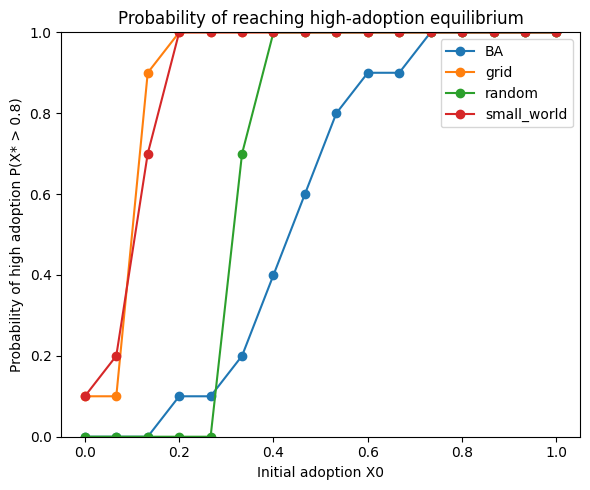

In [16]:
prob_high = (
    df_topo.groupby(["network", "X0"])["high_eq"]
    .mean()
    .reset_index(name="P_high")
)

fig, ax = plt.subplots(figsize=(6,5))
for net, grp in prob_high.groupby("network"):
    ax.plot(grp["X0"], grp["P_high"], marker="o", label=net)

ax.set_xlabel("Initial adoption X0")
ax.set_ylabel("Probability of high adoption P(X* > 0.8)")
ax.set_ylim(0, 1)
ax.set_title("Probability of reaching high-adoption equilibrium")
ax.legend()
plt.tight_layout()
plt.savefig("topology_P_high.png", dpi=150)
plt.show()

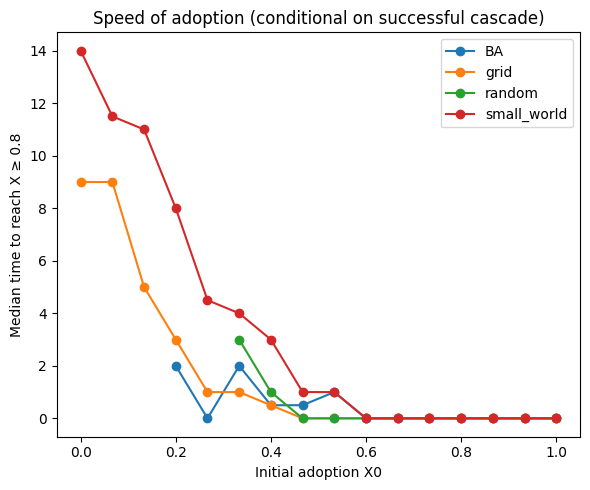

In [17]:
mask_success = df_topo["high_eq"] & df_topo["time_to_80"].notna()
speed = (
    df_topo[mask_success]
    .groupby(["network", "X0"])["time_to_80"]
    .median()
    .reset_index(name="median_time_to_80")
)

fig, ax = plt.subplots(figsize=(6,5))
for net, grp in speed.groupby("network"):
    ax.plot(grp["X0"], grp["median_time_to_80"], marker="o", label=net)

ax.set_xlabel("Initial adoption X0")
ax.set_ylabel("Median time to reach X ≥ 0.8")
ax.set_title("Speed of adoption (conditional on successful cascade)")
ax.legend()
plt.tight_layout()
plt.savefig("topology_speed.png", dpi=150)
plt.show()

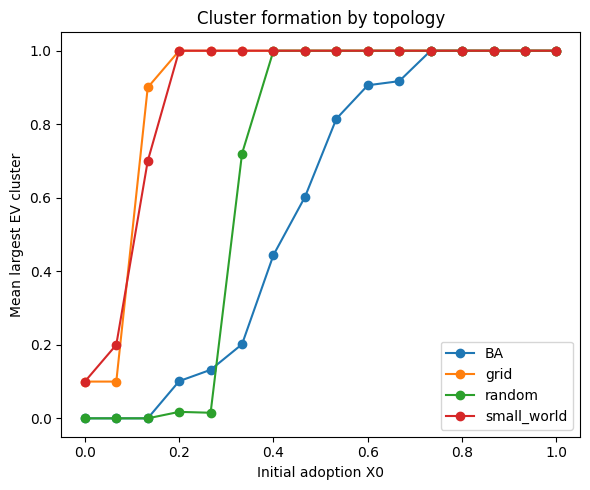

In [18]:
clusters = (
    df_topo.groupby(["network", "X0"])["largest_cluster"]
    .mean()
    .reset_index(name="mean_largest_cluster")
)

fig, ax = plt.subplots(figsize=(6,5))
for net, grp in clusters.groupby("network"):
    ax.plot(grp["X0"], grp["mean_largest_cluster"], marker="o", label=net)

ax.set_xlabel("Initial adoption X0")
ax.set_ylabel("Mean largest EV cluster")
ax.set_title("Cluster formation by topology")
ax.legend()
plt.tight_layout()
plt.savefig("topology_clusters.png", dpi=150)
plt.show()

In [19]:
def critical_X0_for_network(prob_high, net, target=0.5):
    g = prob_high[prob_high["network"] == net].sort_values("X0")
    # simple closest match
    idx = (g["P_high"] - target).abs().idxmin()
    return g.loc[idx, "X0"]

for net in prob_high["network"].unique():
    xcrit = critical_X0_for_network(prob_high, net, target=0.5)
    print(f"{net}: X0_crit ≈ {xcrit:.2f}")

BA: X0_crit ≈ 0.40
grid: X0_crit ≈ 0.00
random: X0_crit ≈ 0.33
small_world: X0_crit ≈ 0.13


# PROPOSED INTERVENTION 

In [20]:
def apply_degree_targeted_seeding(model, frac, seed):
    """
    Convert a fraction `frac` of *highest-degree* ICE nodes to EVs.
    - model: EVStagHuntModel instance
    - frac: fraction of total nodes to turn into EVs (e.g. 0.05 -> 5%)
    - seed: RNG seed for tie-breaking
    """
    rng = np.random.RandomState(seed)

    G = model.G
    agents = list(model.schedule.agents)
    node_to_agent = {agent.pos: agent for agent in agents}

    # current ICE nodes
    ice_nodes = [n for n, ag in node_to_agent.items() if ag.strategy == "D"]
    if not ice_nodes:
        return  # nothing to do

    # sort ICE nodes by degree (highest first)
    deg_view = G.degree(ice_nodes)
    sorted_nodes = sorted(ice_nodes, key=lambda n: deg_view[n], reverse=True)

    # number of nodes to convert
    k = max(1, int(frac * len(node_to_agent)))
    k = min(k, len(sorted_nodes))

    chosen_nodes = sorted_nodes[:k]

    # convert these nodes to EV (C)
    for n in chosen_nodes:
        node_to_agent[n].strategy = "C"

In [21]:
def simulate_with_targeted_seeding(
    network_type,
    X0_frac,
    seed,
    T=250,
    ratio=2.3,
    beta_I=2.0,
    b=1.0,
    g_I=0.005,
    I0=0.05,
    n_nodes=250,
    p=0.05,
    m=2,
    strategy_choice_func="logit",
    tau=3.0,
    # intervention parameters:
    intervention_time=None,   # e.g. 10, 50, 150 or None
    intervention_frac=0.0,         # e.g. 0.02, 0.05, 0.10
) -> dict:
    """
    Run one simulation and possibly apply a degree-targeted seeding intervention.
    Returns:
        final_X, time_to_80, largest_cluster
    """
    a0 = ratio * b - beta_I * I0
    model = EVStagHuntModel(
        a0=a0,
        beta_I=beta_I,
        b=b,
        g_I=g_I,
        I0=I0,
        seed=seed,
        network_type=network_type,
        n_nodes=n_nodes,
        p=p,
        m=m,
        collect=False,
        strategy_choice_func=strategy_choice_func,
        tau=tau,
    )

    # initial random adoption at t=0
    if X0_frac > 0.0:
        set_initial_adopters(
            model,
            X0_frac,
            method="random",
            seed=seed,
        )

    time_to_80 = None
    X_series = []

    for t in range(T):
        # timed, targeted intervention
        if intervention_time is not None and t == intervention_time and intervention_frac > 0.0:
            apply_degree_targeted_seeding(
                model,
                frac=intervention_frac,
                seed=seed + 99999,  # separate RNG
            )

        model.step()
        X = model.get_adoption_fraction()
        X_series.append(X)
        if time_to_80 is None and X >= 0.8:
            time_to_80 = t

    final_X = X_series[-1]

    # cluster formation at final time
    G = model.G
    agents = list(model.schedule.agents)
    ev_nodes = [ag.pos for ag in agents if ag.strategy == "C"]

    if ev_nodes:
        G_ev = G.subgraph(ev_nodes)
        if G_ev.number_of_nodes() > 0:
            components = nx.connected_components(G_ev)
            largest = max(len(c) for c in components)
            largest_cluster = largest / G.number_of_nodes()
        else:
            largest_cluster = 0.0
    else:
        largest_cluster = 0.0

    return {
        "final_X": float(final_X),
        "time_to_80": None if time_to_80 is None else int(time_to_80),
        "largest_cluster": float(largest_cluster),
    }

In [22]:
def run_intervention_sweep(
    network_types=("grid", "small_world", "BA", "random"),
    X0_frac=0.15,
    timings=(None, 10, 50, 150),     # None = baseline
    intensities=(0.0, 0.02, 0.05, 0.10),  # 0.0 used only when timing is None
    n_trials_per_setting=10,
    seed=100,
    **kwargs,
) -> pd.DataFrame:
    """
    Runs interventions across network types, timings, and intensities.
    Returns one row per run with metrics.
    """
    rows = []

    for net in network_types:
        for t_int in timings:
            for frac in intensities:
                # enforce logic: if no intervention time, intensity must be 0 (baseline)
                if t_int is None and frac != 0.0:
                    continue
                if t_int is not None and frac == 0.0:
                    continue  # meaningless

                for r in range(n_trials_per_setting):
                    seed = int(1e6 * (frac + r))
                    metrics = simulate_with_targeted_seeding(
                        network_type=net,
                        X0_frac=X0_frac,
                        seed=seed,
                        intervention_time=t_int,
                        intervention_frac=frac,
                        **kwargs,
                    )
                    rows.append(
                        {
                            "network": net,
                            "X0": X0_frac,
                            "timing": "baseline" if t_int is None else t_int,
                            "intensity": frac,
                            "high_eq": metrics["final_X"] > 0.8,
                            **metrics,
                        }
                    )
    return pd.DataFrame(rows)

In [23]:
df_int = run_intervention_sweep(
    network_types=("grid", "small_world", "BA", "random"),
    X0_frac=0.15,
    timings=(None, 10, 50, 150),
    intensities=(0.0, 0.02, 0.05, 0.10),
    n_trials_per_setting=10,
    T=250,
    ratio=2.3,
    beta_I=2.0,
    b=1.0,
    g_I=0.005,
    I0=0.05,
    n_nodes=250,
)

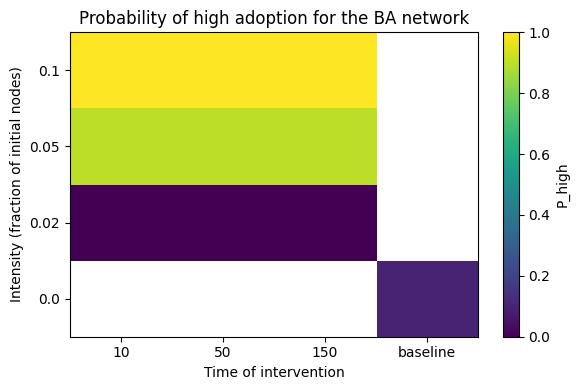

In [24]:
prob_int = (
    df_int.groupby(["network", "timing", "intensity"])["high_eq"]
    .mean()
    .reset_index(name="P_high")
)

net = "BA"
sub = prob_int[prob_int["network"] == net]

pivot = sub.pivot(index="intensity", columns="timing", values="P_high")

fig, ax = plt.subplots(figsize=(6,4))
im = ax.imshow(pivot.values, origin="lower", aspect="auto", vmin=0, vmax=1)
ax.set_xticks(range(pivot.shape[1]))
ax.set_xticklabels(pivot.columns)
ax.set_yticks(range(pivot.shape[0]))
ax.set_yticklabels(pivot.index)
plt.colorbar(im, ax=ax, label="P_high")
ax.set_xlabel("Time of intervention")
ax.set_ylabel("Intensity (fraction of initial nodes)")
ax.set_title(f"Probability of high adoption for the BA network")
plt.tight_layout()
plt.savefig("BA_intervention_heatmap.png", dpi=150)
plt.show()

In [25]:
prob_int = (
    df_int.groupby(["network", "timing", "intensity"])["high_eq"]
    .mean()
    .reset_index(name="P_high")
)

speed_int = (
    df_int.groupby(["network", "timing", "intensity"])["time_to_80"]
    .median()
    .reset_index(name="median_speed")
)

clusters_int = (
    df_int.groupby(["network", "timing", "intensity"])["largest_cluster"]
    .mean()
    .reset_index(name="mean_largest_cluster")
)

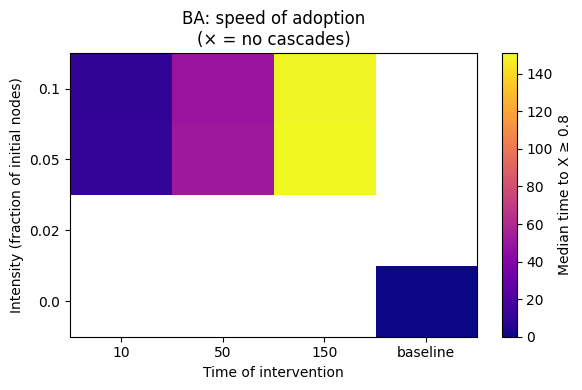

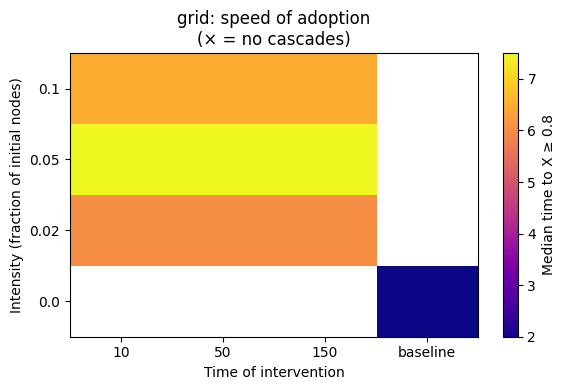

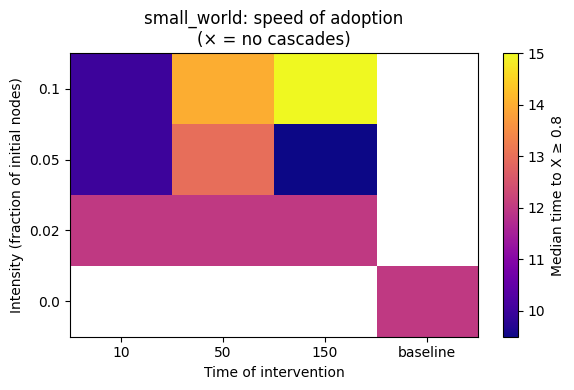

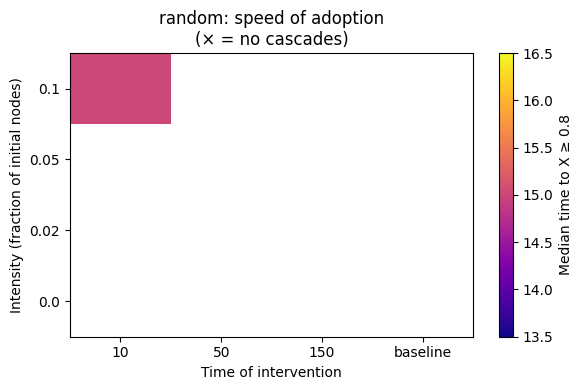

In [26]:
def speed_heatmap_for_network(net):
    sub = speed_int[speed_int["network"] == net]
    pivot = sub.pivot(index="intensity", columns="timing", values="median_speed")

    fig, ax = plt.subplots(figsize=(6,4))
    
    # Plot values where cascades occurred
    im = ax.imshow(
        pivot.values,
        origin="lower",
        aspect="auto",
        cmap="plasma",
    )

    # Overlay explicit marking for missing values (baseline failures)
    for i in range(pivot.shape[0]):
        for j in range(pivot.shape[1]):
            if np.isnan(pivot.values[i, j]):
                ax.text(
                    j, i, "×",  # clear cross marker
                    ha="center", va="center",
                    color="white", fontsize=14, fontweight="bold"
                )

    ax.set_xticks(range(pivot.shape[1]))
    ax.set_xticklabels(pivot.columns)
    ax.set_yticks(range(pivot.shape[0]))
    ax.set_yticklabels(pivot.index)

    plt.colorbar(im, ax=ax, label="Median time to X ≥ 0.8")
    ax.set_xlabel("Time of intervention")
    ax.set_ylabel("Intensity (fraction of initial nodes)")
    ax.set_title(f"{net}: speed of adoption\n(× = no cascades)")
    plt.tight_layout()
    plt.show()

speed_heatmap_for_network("BA")
speed_heatmap_for_network("grid")   
speed_heatmap_for_network("small_world")
speed_heatmap_for_network("random")

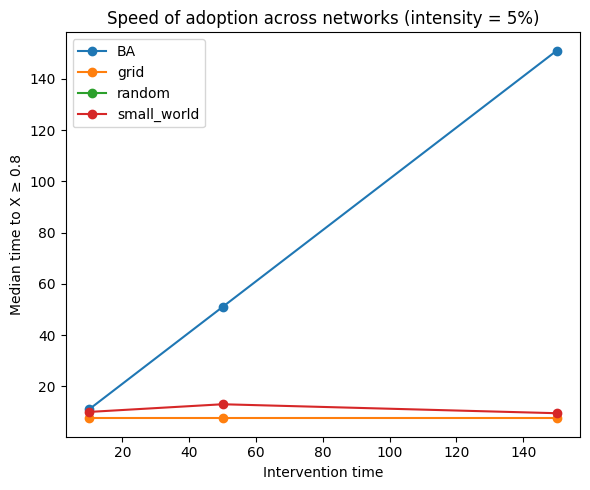

In [28]:
fig, ax = plt.subplots(figsize=(6,5))

for net, grp in speed_int.groupby("network"):
    # choose one intensity level (e.g. 0.05)
    sel = grp[grp["intensity"] == 0.05].sort_values("timing")
    ax.plot(sel["timing"], sel["median_speed"], marker="o", label=net)

ax.set_xlabel("Intervention time")
ax.set_ylabel("Median time to X ≥ 0.8")
ax.set_title("Speed of adoption across networks (intensity = 5%)")
ax.legend()
plt.tight_layout()
plt.show()


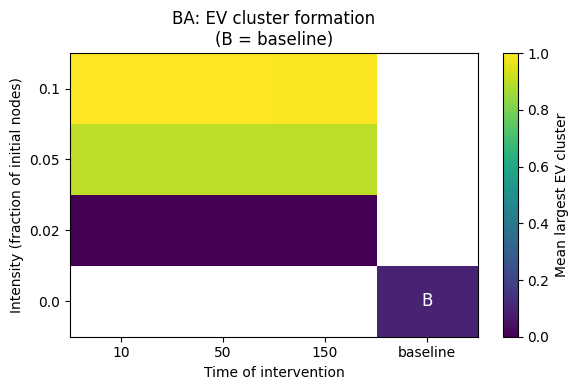

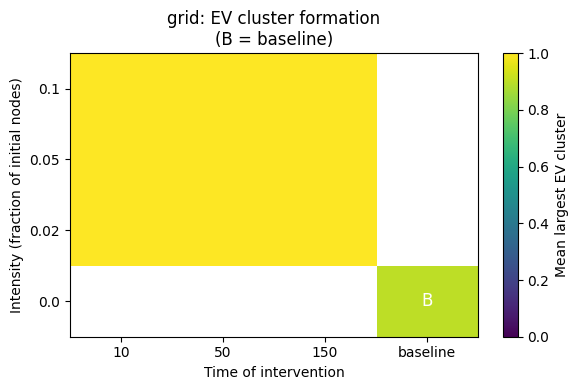

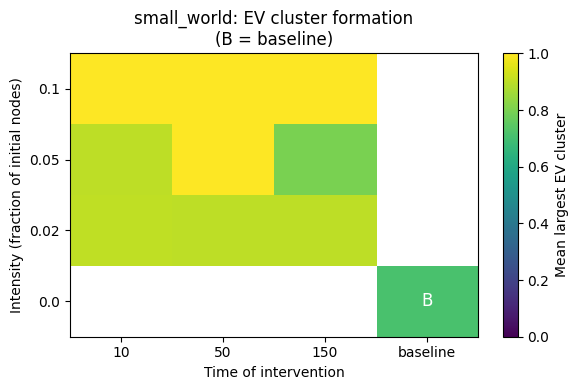

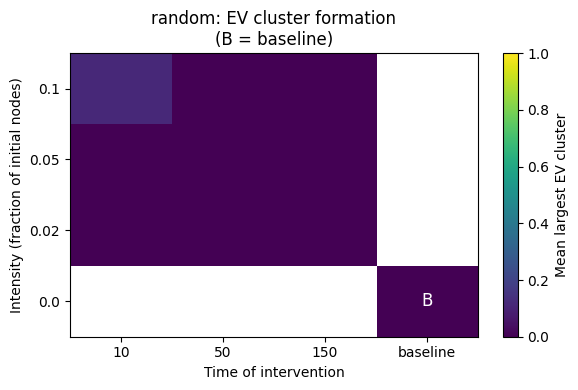

In [29]:
def cluster_heatmap_for_network(net):
    sub = clusters_int[clusters_int["network"] == net]
    pivot = sub.pivot(index="intensity", columns="timing", values="mean_largest_cluster")

    fig, ax = plt.subplots(figsize=(6,4))
    im = ax.imshow(
        pivot.values,
        origin="lower",
        aspect="auto",
        cmap="viridis",
        vmin=0,
        vmax=1
    )

    # Annotate baseline cell for clarity
    if "baseline" in pivot.columns and 0.0 in pivot.index:
        j = list(pivot.columns).index("baseline")
        i = list(pivot.index).index(0.0)
        ax.text(j, i, "B", color="white", ha="center", va="center", fontsize=12)

    ax.set_xticks(range(pivot.shape[1]))
    ax.set_xticklabels(pivot.columns)
    ax.set_yticks(range(pivot.shape[0]))
    ax.set_yticklabels(pivot.index)

    plt.colorbar(im, ax=ax, label="Mean largest EV cluster")
    ax.set_xlabel("Time of intervention")
    ax.set_ylabel("Intensity (fraction of initial nodes)")
    ax.set_title(f"{net}: EV cluster formation\n(B = baseline)")
    plt.tight_layout()
    plt.show()


# EXAMPLES:
cluster_heatmap_for_network("BA")
cluster_heatmap_for_network("grid")
cluster_heatmap_for_network("small_world")
cluster_heatmap_for_network("random")


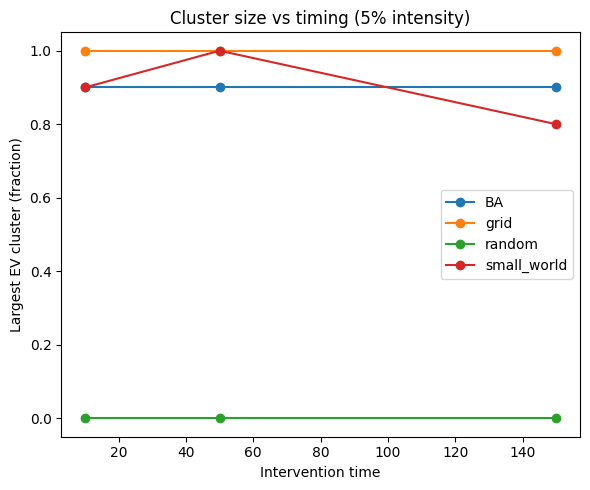

In [30]:
fig, ax = plt.subplots(figsize=(6,5))

for net, grp in clusters_int.groupby("network"):
    sel = grp[grp["intensity"] == 0.05].sort_values("timing")
    ax.plot(sel["timing"], sel["mean_largest_cluster"], marker="o", label=net)

ax.set_xlabel("Intervention time")
ax.set_ylabel("Largest EV cluster (fraction)")
ax.set_title("Cluster size vs timing (5% intensity)")
ax.legend()
plt.tight_layout()
plt.show()